# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [0]:
# %pycat /content/drive/My Drive/CV/assignment1/cs231n/classifiers/softmax.py

In [2]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
import os
import importlib

WRK_DIR = "/content/drive/My Drive/CV/assignment1"
# WRK_DIR = "/content/drive/My Drive/CV/assignment1/cs231n"
sys.path.append(WRK_DIR)

In [0]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [5]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = os.path.join(WRK_DIR,'cs231n/datasets/cifar-10-batches-py')
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## softmax.py - math explanation


$o_i$ and derivative of $o_i$:
$$ o_i = \sum_{c}w_{ic}x_c $$
$$ \frac{\partial o_i}{\partial w_{ic}} = x_c$$

Sofmax ($c \in C $ - categories of classification):
$$ p_j = e^{o_j} \big/ {\sum_{c \in C}{e^{o_c}}} 
=e^{o_j} \bigg( \sum_{c \in C}{e^{o_c}} \bigg)^{-1}
$$

normalisation trick to prevent large variatio of numerator and denominator:
$$  
p_j = e^{o_j} \big/ {\sum_{c \in C}{e^{o_c}}} 
= A e^{o_j} \big/ \bigg[ A{\sum_{c \in C}{e^{o_c}}} \bigg]=
$$
$$
=e^{o_j+log\ A} \big/ {\sum_{c \in C}{e^{o_c+log\ A}}}
$$
$$
where\ A=-log[max(o_1,..,o_j,...o_C)]
$$

derivative of softmax by $o_j$:
$$ 
\frac{\partial p_j}{\partial o_j}
=\frac{\partial }{\partial o_j} \bigg[ e^{o_j} \big/ {\sum_{c \in C}{e^{o_c}}} \bigg]
=\frac
  {e^{o_j} \sum_{c}{e^{o_c}} + e^{o_j}e^{o_j}} 
  { \big( \sum_{c}{e^{o_c}} \big)^2}
=p_j-(p_j)^2=p_j(1-p_j)
$$

derivative of softmax by $o_i$ ($i \ne j$):
$$\frac{\partial p_j}{\partial o_i}
=\frac{\partial}{\partial o_j} \bigg[
e^{o_j} \big( \sum_{c}{e^{o_c}} \big)^{-1}\bigg]
= - e^{o_j} \big( \sum_{c}{e^{o_c}} \big)^{-2} e^{o_i}
=$$
$$=- \frac{e^{o_j}e^{o_j}}{ \big( \sum_{c}{e^{o_c}} \big)^{-2} } = - p_ip_j
$$

cross-entropy loss (aka softmax loss):
$$L=-\sum_{c}{y_c log(p_c)}$$
derivatives for cross-entropy loss ($p_c$ - softmax):
$$
\frac{\partial L}{\partial o_j}
=\frac{\partial}{\partial o_j}
\bigg[-\sum_{c}{y_c log(p_c)} \bigg]
=-\sum_{c}\bigg[
{y_c \frac{\partial (log\ p_c)}{\partial o_j}}
\bigg]=
$$
$$=-y_j \frac{1}{p_j}p_j(1-p_j)+
\sum_{c \ne j}
\bigg[y_c\frac{1}{p_c}p_cp_j\bigg]
=$$
$$=-y_j+y_jp_j
+\sum_{c \ne j}\bigg[
y_cp_j
\bigg]
=-y_j+y_jp_j+p_j\sum_{c \ne j}{y_c}=
$$
$$=-y_j+p_j \sum_{c}{y_c}=-y_j+p_j=p_j-y_j$$
So the derivative of cross-entropy is the following
$$ \frac{\partial L}{\partial o_j} =  p_j-y_j$$

vectorised version:
$$  $$

## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [6]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.369617
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 



In [7]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.894709 analytic: 0.894709, relative error: 1.032287e-08
numerical: 2.496383 analytic: 2.496383, relative error: 1.445052e-08
numerical: -0.809105 analytic: -0.809105, relative error: 1.909247e-08
numerical: 1.277249 analytic: 1.277249, relative error: 2.010171e-08
numerical: 1.982292 analytic: 1.982292, relative error: 1.869949e-08
numerical: -0.872942 analytic: -0.872942, relative error: 1.965247e-08
numerical: 2.206726 analytic: 2.206726, relative error: 4.998156e-09
numerical: 2.661239 analytic: 2.661239, relative error: 4.360962e-09
numerical: -0.172323 analytic: -0.172323, relative error: 2.292888e-07
numerical: -0.384713 analytic: -0.384713, relative error: 1.069444e-07
numerical: 2.568830 analytic: 2.568830, relative error: 1.700486e-08
numerical: 0.843607 analytic: 0.843607, relative error: 5.440168e-09
numerical: -2.777241 analytic: -2.777241, relative error: 2.449397e-09
numerical: 0.025908 analytic: 0.025908, relative error: 3.027785e-06
numerical: -3.256915 ana

In [8]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
import time
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.369617e+00 computed in 0.094478s
vectorized loss: 2.369617e+00 computed in 0.020296s
Loss difference: 0.000000
Gradient difference: 0.000000


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-6, 2e-6,3e-6]
regularization_strengths = [3e4,4e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

grid = [
    (lr, reg, n_iter) 
    for lr in learning_rates 
    for reg in regularization_strengths
    for n_iter in [100, 200,300]
]

for idx, (lr,reg, n_iter) in enumerate(grid):
    est = Softmax()
    est.train(X_train, y_train,learning_rate=lr, reg=reg, num_iters=n_iter)
    y_train_pred = est.predict(X_train)
    y_test_pred = est.predict(X_test)
    train_acc = np.mean(y_train_pred==y_train)
    test_acc = np.mean(y_test_pred==y_test)
    results[(lr, reg)] = (train_acc, test_acc)
    if best_val<test_acc:
        best_val = test_acc
        best_softmax = est
    print("done ", idx,"/",len(grid))


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

done  0 / 27
done  1 / 27
done  2 / 27
done  3 / 27
done  4 / 27
done  5 / 27
done  6 / 27
done  7 / 27
done  8 / 27
done  9 / 27
done  10 / 27
done  11 / 27
done  12 / 27
done  13 / 27
done  14 / 27
done  15 / 27
done  16 / 27
done  17 / 27
done  18 / 27
done  19 / 27
done  20 / 27
done  21 / 27
done  22 / 27
done  23 / 27
done  24 / 27
done  25 / 27
done  26 / 27
lr 1.000000e-06 reg 3.000000e+04 train accuracy: 0.333694 val accuracy: 0.356000
lr 1.000000e-06 reg 4.000000e+04 train accuracy: 0.332980 val accuracy: 0.346000
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.324143 val accuracy: 0.332000
lr 2.000000e-06 reg 3.000000e+04 train accuracy: 0.316265 val accuracy: 0.323000
lr 2.000000e-06 reg 4.000000e+04 train accuracy: 0.306184 val accuracy: 0.316000
lr 2.000000e-06 reg 5.000000e+04 train accuracy: 0.278449 val accuracy: 0.274000
lr 3.000000e-06 reg 3.000000e+04 train accuracy: 0.308388 val accuracy: 0.322000
lr 3.000000e-06 reg 4.000000e+04 train accuracy: 0.296510 val acc

In [10]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.356000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



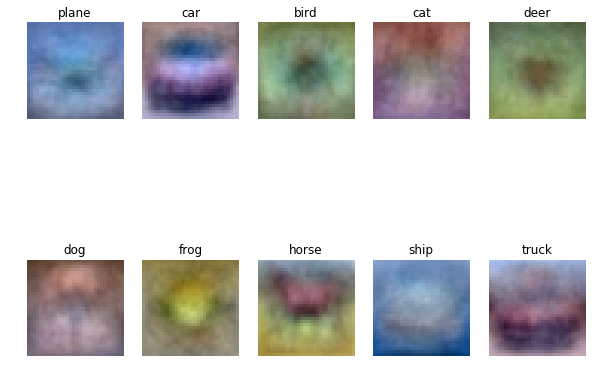

In [11]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])